In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats.mstats import winsorize
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
# Dataset available at https://data.cityofnewyork.us/City-Government/Good-Food-Purchasing-Data/usrf-za7k
path = 'Good_Food_Purchasing_Data.csv'
df_0 = pd.read_csv(path)

In [3]:
df_0.shape

(17208, 12)

In [4]:
df_0.columns

Index(['Agency', 'Time Period', 'Food Product Group', 'Food Product Category',
       'Product Name', 'Product Type', 'Origin Detail', 'Distributor',
       'Vendor', '# of Units', 'Total Weight in lbs', 'Total Cost'],
      dtype='object')

In [5]:
df_0.head()

,Agency,Time Period,Food Product Group,Food Product Category,Product Name,Product Type,Origin Detail,Distributor,Vendor,# of Units,Total Weight in lbs,Total Cost
0,Administration for Childrens Services,2018-2019,Meals,Meals,"baby food, dinner, assorted","Stage 2 Baby Food Dinner, Assorted Variety",Beech-Nut,Babylab Inc.,Babylab Inc.,40.0,100.0,560.0
1,Administration for Childrens Services,2018-2019,Meals,Meals,"baby food, dinner, assorted","Stage 3 Baby Food Dinner, Assorted Variety",Beech-Nut,Babylab Inc.,Babylab Inc.,40.0,106.0,600.0
2,Administration for Childrens Services,2018-2019,Meals,Meals,"baby food, formula","Premium Nursette Ready-to-Feed Infant Formula,...",Enfamil,Babylab Inc.,Babylab Inc.,200.0,1200.0,16200.0
3,Administration for Childrens Services,2018-2019,Beverages,Beverages,"juice, fruit punch, ss","100% Juice Variety Pack, 4 fl oz bottles",Enfamil,Babylab Inc.,Babylab Inc.,100.0,600.0,1940.0
4,Administration for Childrens Services,2018-2019,Condiments & Snacks,Condiments & Snacks,"cereal, baby, oatmeal",Single Grain Oatmeal Baby Cereal,Enfamil,Babylab Inc.,Babylab Inc.,10.0,60.0,290.0


In [6]:
df_0.dtypes

Agency                    object
Time Period               object
Food Product Group        object
Food Product Category     object
Product Name              object
Product Type              object
Origin Detail             object
Distributor               object
Vendor                    object
# of Units               float64
Total Weight in lbs      float64
Total Cost               float64
dtype: object

In [7]:
df_0.describe()

,# of Units,Total Weight in lbs,Total Cost
count,1.715200e+04,1.715000e+04,3.767000e+03
mean,1.915848e+04,2.886157e+04,1.398539e+05
std,5.987577e+05,3.260171e+05,4.243162e+05
min,-3.600000e+01,-2.330000e+02,0.000000e+00
25%,3.000000e+00,2.200000e+01,1.210000e+03
50%,1.700000e+01,1.470000e+02,1.570800e+04
75%,2.110000e+02,1.811500e+03,9.308300e+04
max,5.050947e+07,2.525474e+07,9.110741e+06


## Cleaning
From the cell above, I noticed a couple of things:
- min of `Total Weight in lbs` and `# of Units` is negative, which doesn't make sense.
- min `Total Cost` is 0 which would make sense if either the item being sold was sold for free or `# of Units` for it was 0. Both of those features being 0 when `Total Cost` is 0 doesn't make sense.

In [8]:
df_0.isna().sum() # check for null values per column

Agency                       0
Time Period                  0
Food Product Group           0
Food Product Category        0
Product Name                 1
Product Type                 0
Origin Detail             2149
Distributor                911
Vendor                     486
# of Units                  56
Total Weight in lbs         58
Total Cost               13441
dtype: int64

In [9]:
# Dropping rows with NaN values in any of the specified columns
# df = df.dropna(subset=['# of Units', 'Total Weight in lbs', 'Total Cost'])
# df[(df["Total Cost"].isna()) | (df["# of Units"].isna()) | (df["Total Weight in lbs"].isna())]

In [10]:
# Set Total Cost and Total Weight in lbs to 0 where # of Units = 0
# df.loc[df["# of Units"] == 0, ["Total Cost"]] = 0
# df

### Rows where the `Total Weight in lbs` or `# of Units` is less than 0

In [11]:
df_0[(df_0["Total Weight in lbs"] < 0) | (df_0["# of Units"] < 0)].shape

(6, 12)

In [12]:
df_0.shape

(17208, 12)

### Drop the rows you found above

In [13]:
df_1 = df_0[~((df_0["Total Weight in lbs"] < 0) | (df_0["# of Units"] < 0))]
df_1.shape

(17202, 12)

### Rows where `Total Cost` is 0

In [14]:
df_1[df_1["Total Cost"] == 0].shape

(5, 12)

### Drop the rows you found above

In [15]:
df_2 = df_1[~(df_1["Total Cost"] == 0)]
df_2.shape

(17197, 12)

In [16]:
df_2.describe()

,# of Units,Total Weight in lbs,Total Cost
count,1.714200e+04,1.713900e+04,3.762000e+03
mean,1.916966e+04,2.888011e+04,1.400398e+05
std,5.989322e+05,3.261209e+05,4.245675e+05
min,0.000000e+00,0.000000e+00,1.000000e+00
25%,3.000000e+00,2.200000e+01,1.212750e+03
50%,1.700000e+01,1.470000e+02,1.570800e+04
75%,2.117500e+02,1.818000e+03,9.318875e+04
max,5.050947e+07,2.525474e+07,9.110741e+06


In [17]:
df_2.isna().sum()

Agency                       0
Time Period                  0
Food Product Group           0
Food Product Category        0
Product Name                 1
Product Type                 0
Origin Detail             2149
Distributor                911
Vendor                     486
# of Units                  55
Total Weight in lbs         58
Total Cost               13435
dtype: int64

## Impute

In [34]:
# impute Graduated and Family_Size features with median values
impute_mode = SimpleImputer(strategy = 'median')
impute_mode.fit(df_2[['Total Cost']])

df_2[['Total Cost']] = impute_mode.transform(df_2[['Total Cost']])

C:\Users\rahul\AppData\Local\Temp\ipykernel_18268\829543322.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2[['Total Cost']] = impute_mode.transform(df_2[['Total Cost']])


## Boxplots

<Axes: xlabel='Total Cost'>

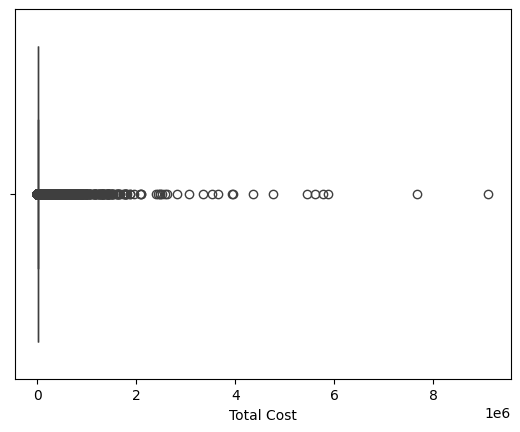

In [35]:
sns.boxplot(x=df_2["Total Cost"])

<Axes: xlabel='Total Weight in lbs'>

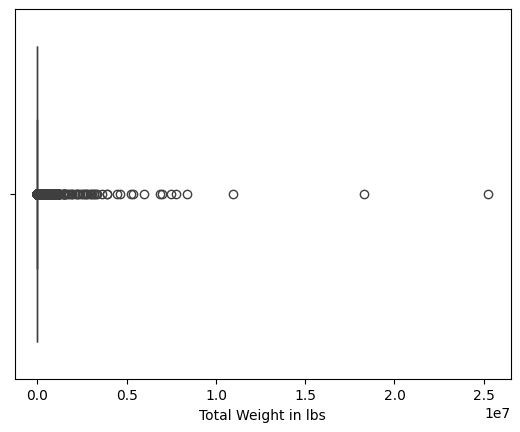

In [36]:
sns.boxplot(x=df_2["Total Weight in lbs"])

<Axes: xlabel='# of Units'>

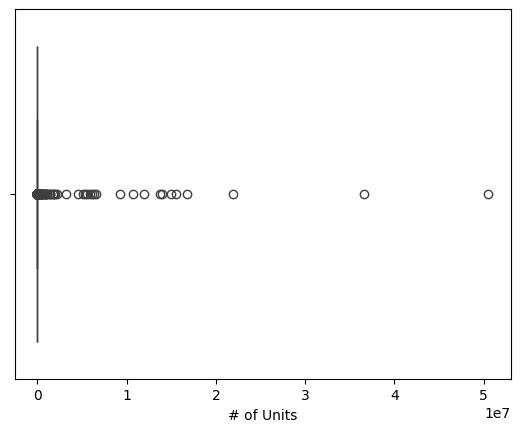

In [37]:
sns.boxplot(x=df_2["# of Units"])

## EDA

## What is the distribution of Total Cost of the foods?

<Axes: xlabel='Total Cost', ylabel='Count'>

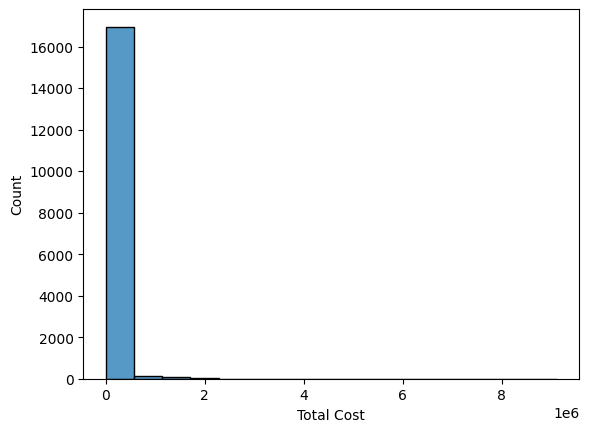

In [38]:
sns.histplot(data=df_2, x="Total Cost")

## Any strong correlations between features?

<Axes: >

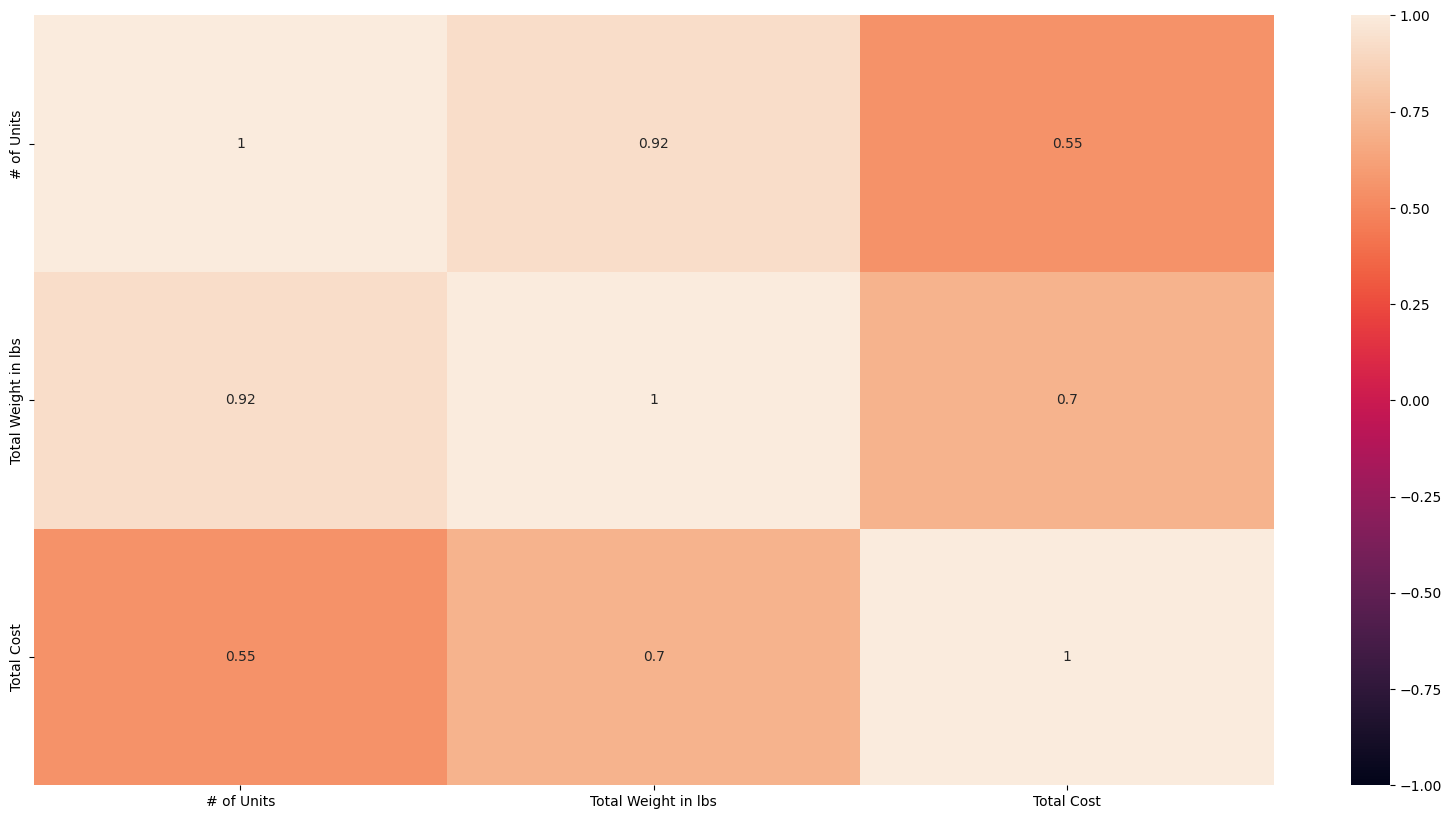

In [39]:
filtered_df = df_2.iloc[:, 9:12]
# correlation matrix
myColors = ("red","white","blue")
cmap1 = clr.LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
corr = filtered_df.corr()
mask = np.zeros_like(corr, dtype=bool)
#mask[np.triu_indices_from(mask)]= True
plt.figure(figsize=(20,10))
sns.heatmap(corr, mask = mask, vmin = -1, vmax = 1, annot=True)

In [ ]:
# winsorize Total Cost column to get rid of outliers
# df.loc[:, "Total Cost"] = winsorize(df["Total Cost"], limits=(None, 0.0005))

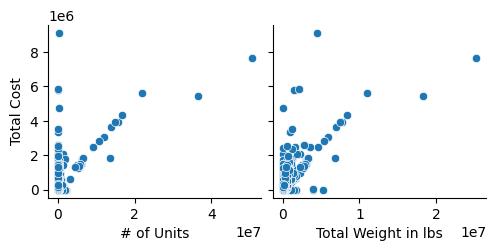

In [40]:
# Let Target be Total_cost
x_vars = ["# of Units", "Total Weight in lbs"]
y_vars = ["Total Cost"]
sns.pairplot(filtered_df, x_vars=x_vars, y_vars=y_vars)

## How many foods per Food Product Group?

<Axes: xlabel='count', ylabel='Food Product Group'>

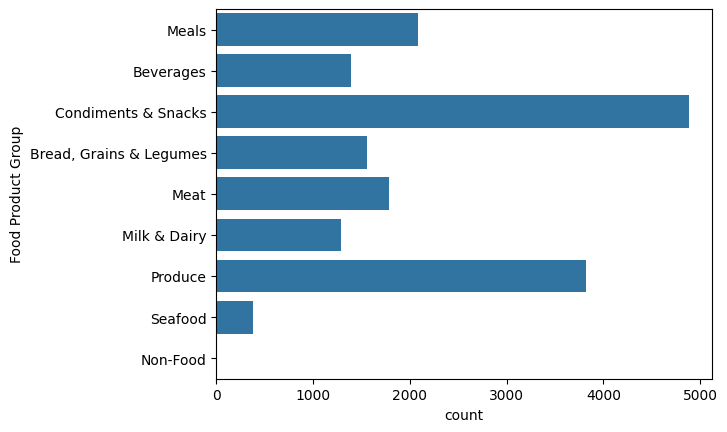

In [41]:
sns.countplot(df_2, y="Food Product Group", orient='h')

## How many foods per food product category?

<Axes: xlabel='count', ylabel='Food Product Category'>

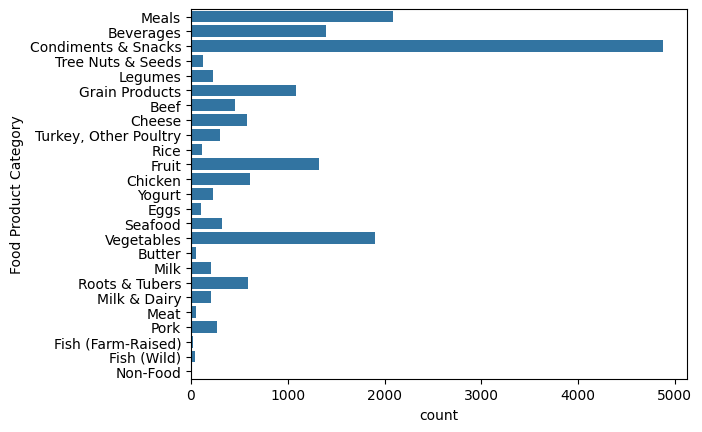

In [42]:
sns.countplot(df_2, y="Food Product Category", orient='h')

## More Boxplots 

<Axes: xlabel='Total Cost', ylabel='Food Product Category'>

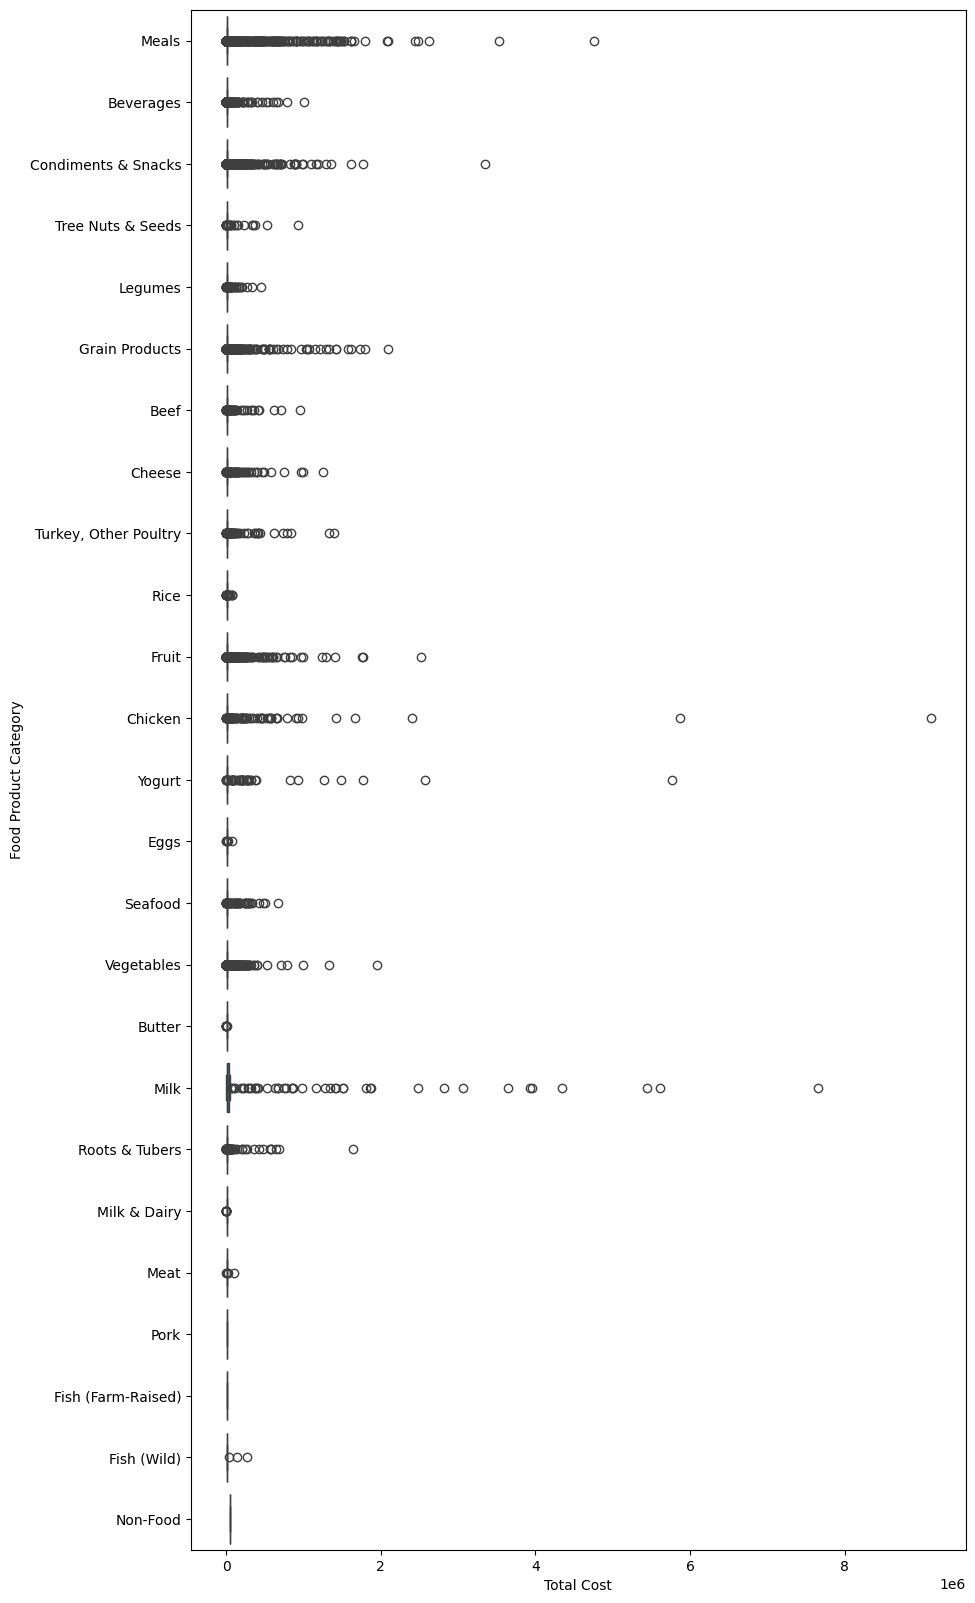

In [43]:
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed
sns.boxplot( x="Total Cost", y="Food Product Category", data=df_2)

<Axes: xlabel='Total Cost', ylabel='Food Product Group'>

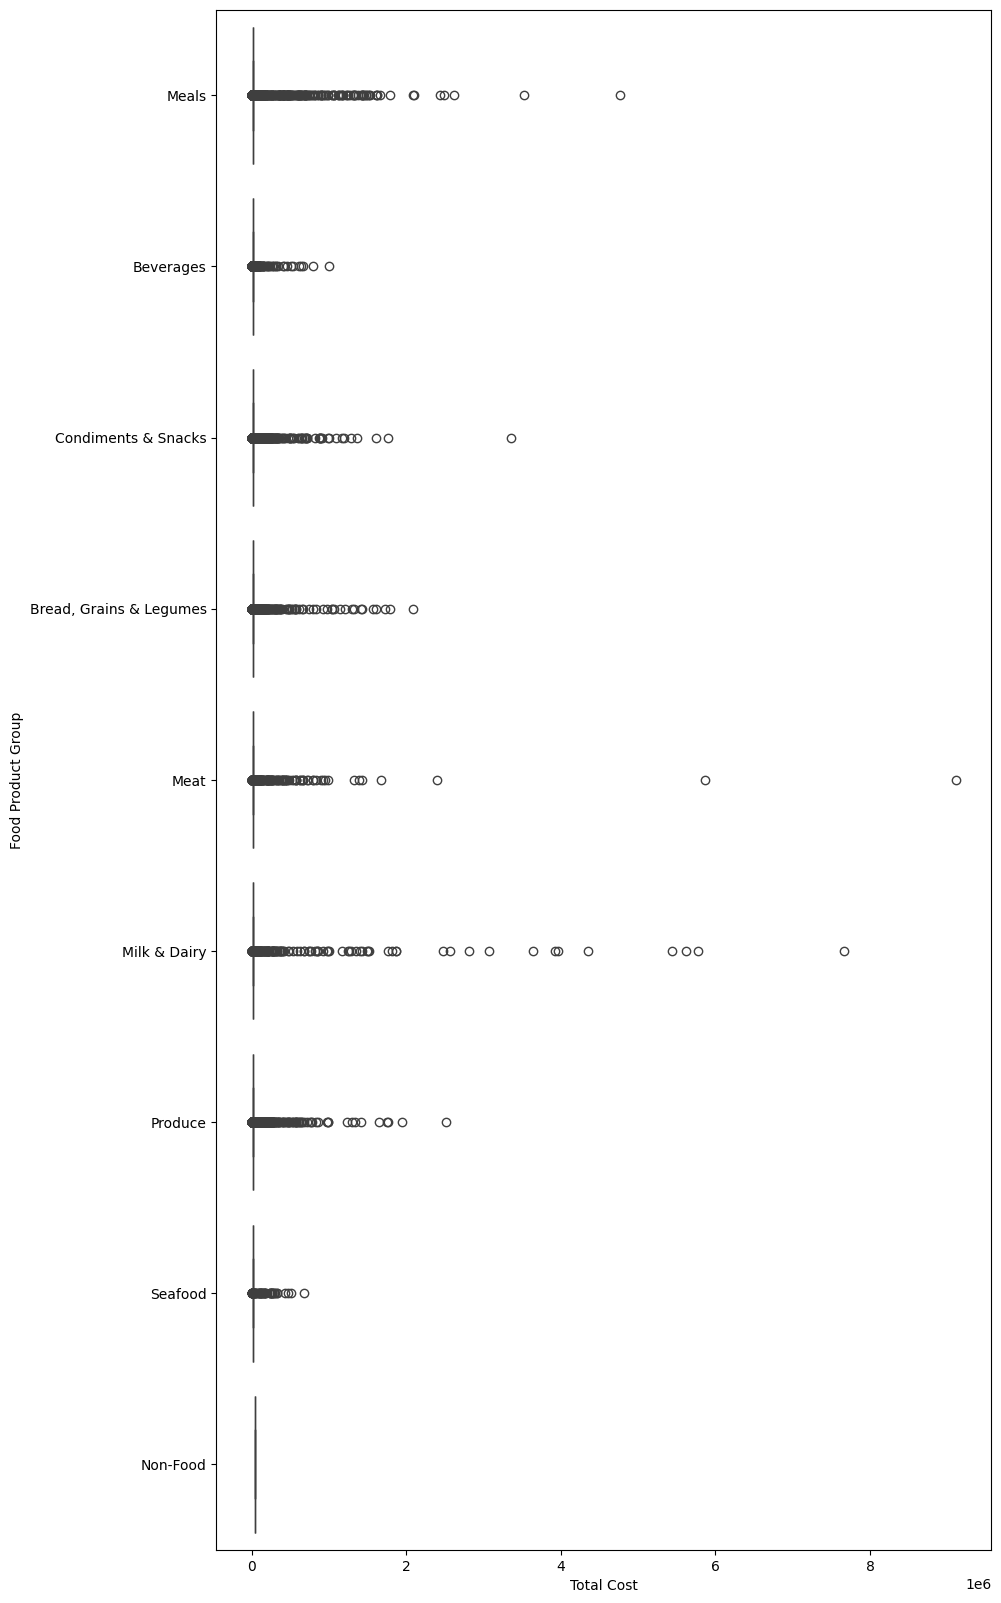

In [44]:
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed
sns.boxplot( x="Total Cost", y="Food Product Group", data=df_2)

<Axes: xlabel='Total Cost', ylabel='Vendor'>

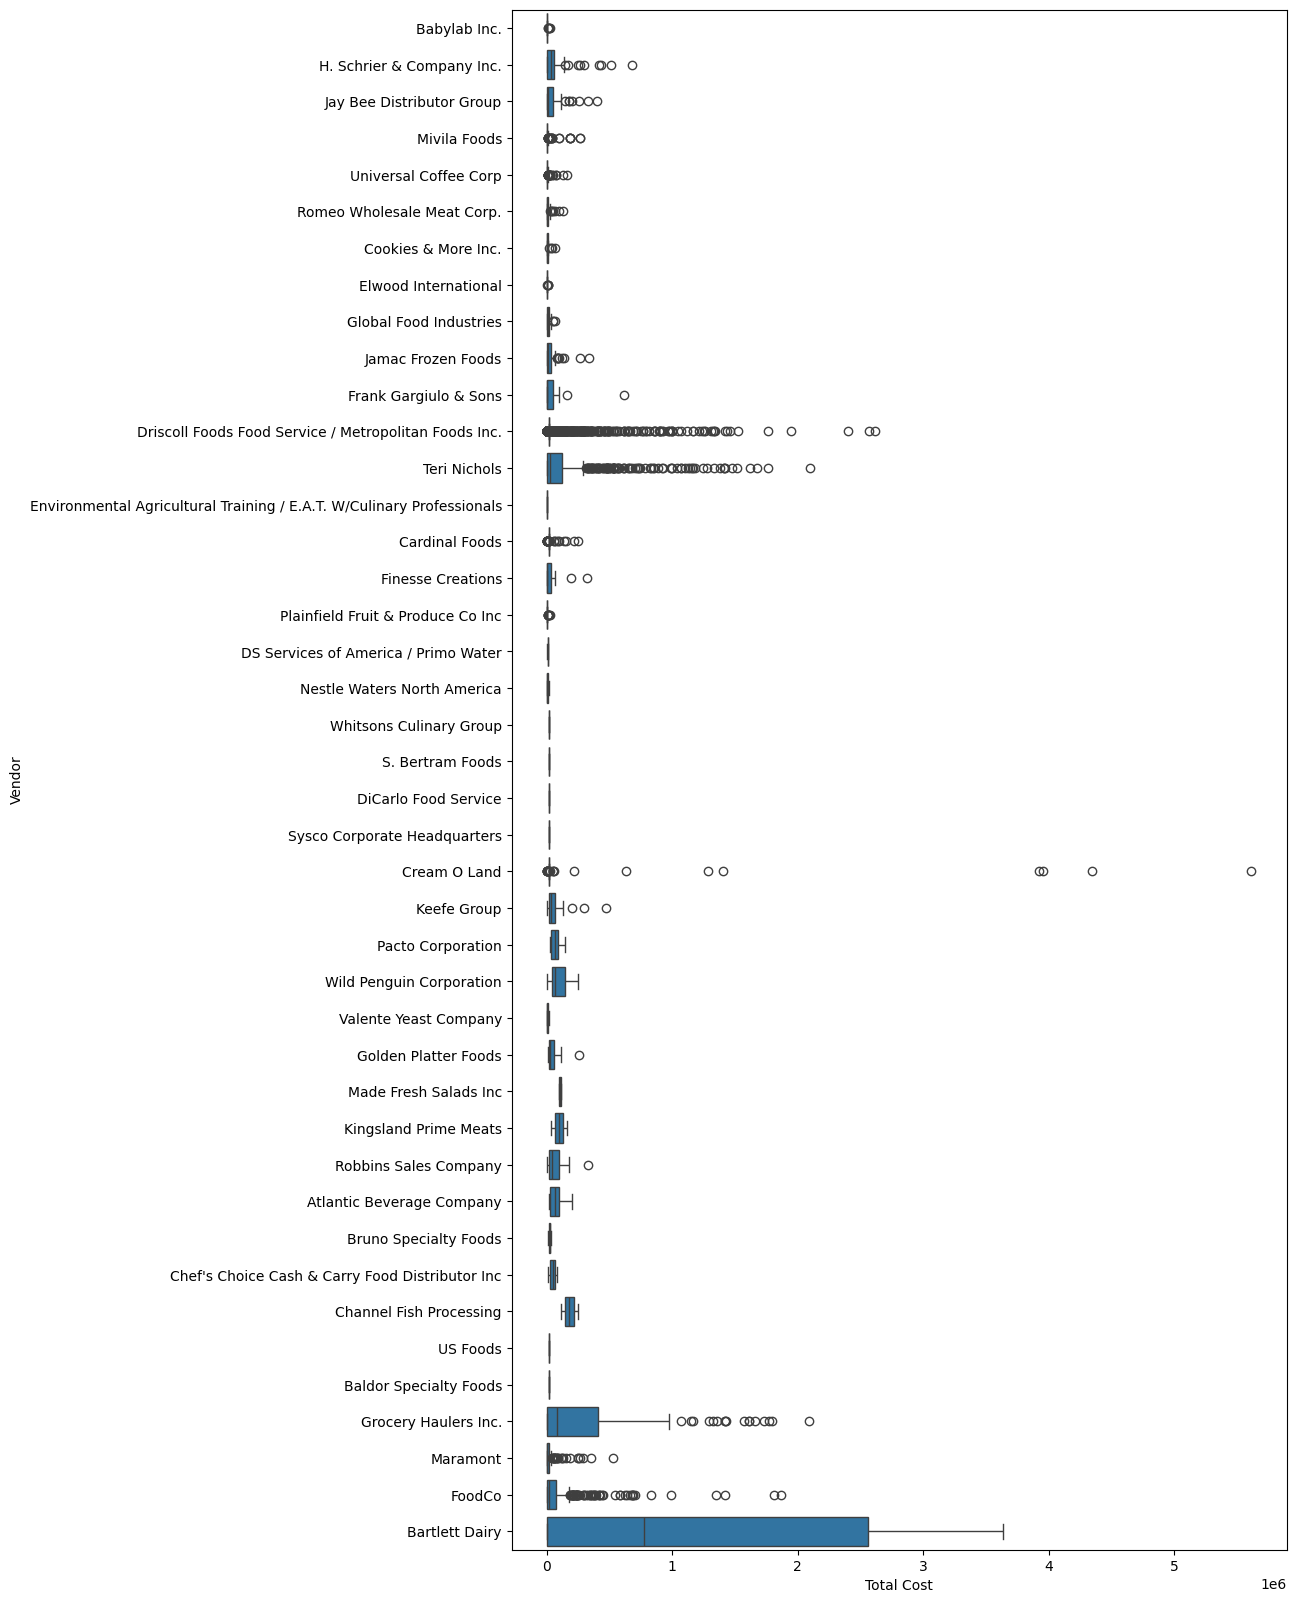

In [45]:
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed
sns.boxplot( x="Total Cost", y="Vendor", data=df_2)

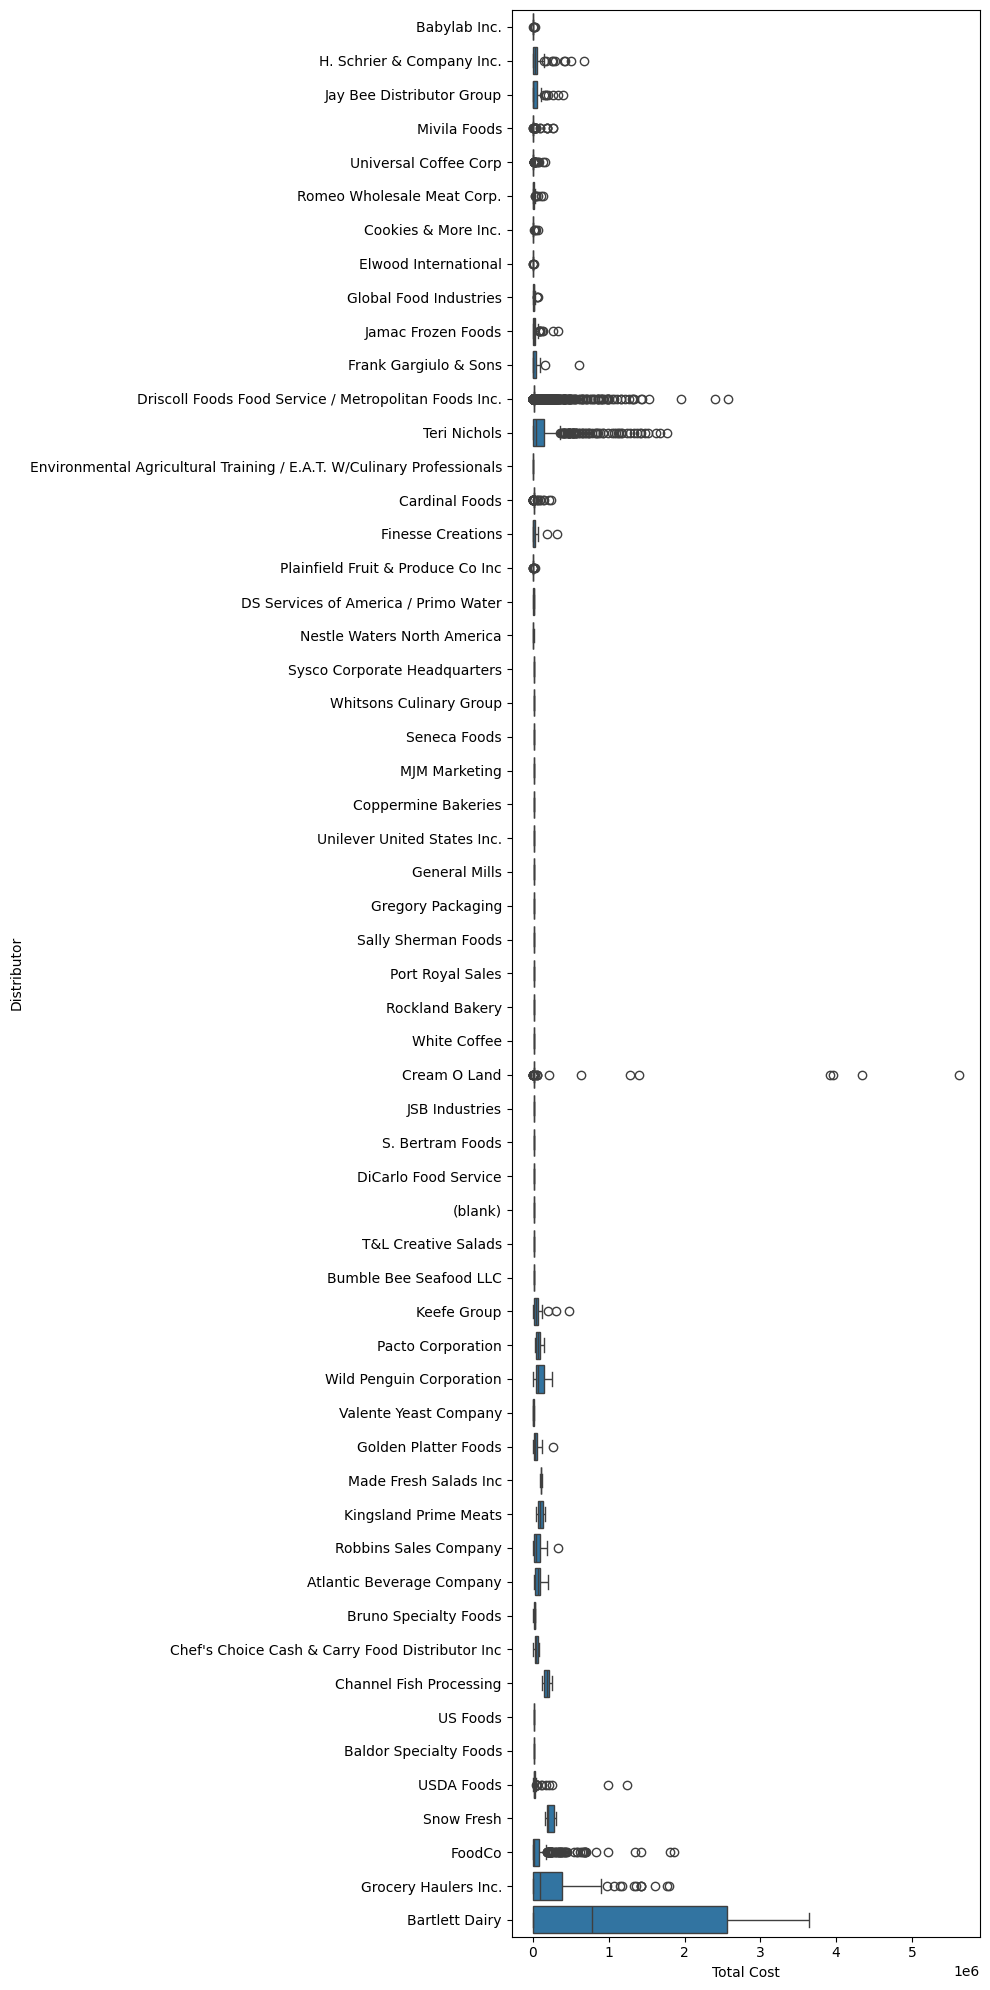

In [53]:
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed
sns.boxplot( x="Total Cost", y="Distributor", data=df_2)
plt.tight_layout()  # Adjust layout for better visibility

## Show top 5 highest priced products from top 5 vendors

<Axes: title={'center': 'Top Distributors'}, xlabel='Distributor'>

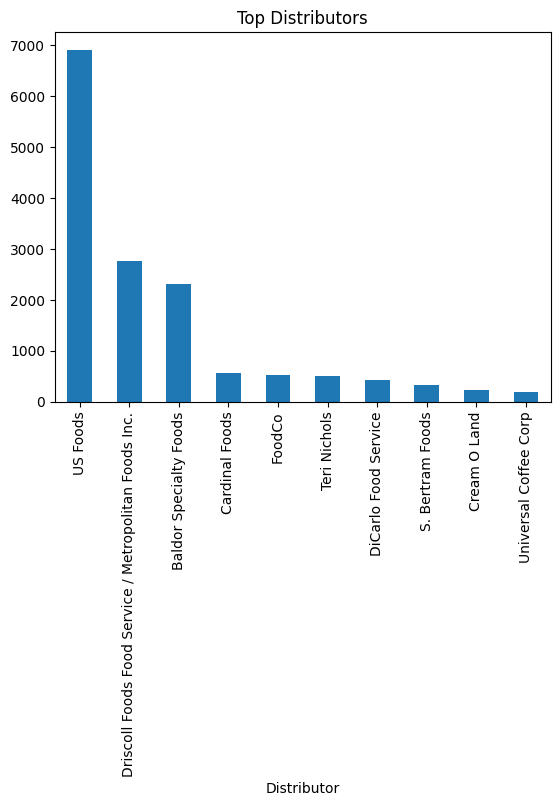

In [46]:
df_2["Distributor"].value_counts() \
.head(10) \
.plot(kind="bar", title="Top Distributors")

In [26]:
# df_2.query('Total Cost > 1000')["Distributor"].value_counts() \
# .head(10) \
# .plot(kind="bar", title="Top Distributors whose food products were priced at greater than 1000 USD")

## Scaling & Encoding
- Scale: '# of Units', 'Total Weight in lbs', 'Total Cost'
- Encode: 'Food Product Category', 'Food Product Group'

# review all encoding techniques and normalizing techniques

In [47]:
df_2.describe()

,# of Units,Total Weight in lbs,Total Cost
count,1.714200e+04,1.713900e+04,1.719700e+04
mean,1.916966e+04,2.888011e+04,4.290672e+04
std,5.989322e+05,3.261209e+05,2.051020e+05
min,0.000000e+00,0.000000e+00,1.000000e+00
25%,3.000000e+00,2.200000e+01,1.570800e+04
50%,1.700000e+01,1.470000e+02,1.570800e+04
75%,2.117500e+02,1.818000e+03,1.570800e+04
max,5.050947e+07,2.525474e+07,9.110741e+06


In [48]:
# filter out some columns
df = df_2[[# 'Agency', 'Time Period', 
    #    'Product Name', 'Product Type', 'Origin Detail', 'Distributor',
    #    'Vendor', 
    #    'Food Product Category',
         'Vendor',  'Food Product Group', '# of Units', 'Total Weight in lbs', 'Total Cost']].copy()

In [49]:
# Define numeric and categorical features
numeric_features = ['# of Units', 'Total Weight in lbs']
categorical_features = ['Vendor', 'Food Product Group']

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

xgb_model = XGBRegressor()

model = Pipeline(steps=[("preprocessor", preprocessor), ("model", xgb_model)])

#### exhaustively search for the optimal hyperparameters

In [ ]:
# set up our search grid
param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

In [50]:
# Split data into features and target
X = df.drop('Total Cost', axis=1)
y = df['Total Cost']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['# of Units',
                                                   'Total Weight in lbs']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Vendor',
                                                   'Food Product Group'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, co...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

## Evaluate model


In [52]:
# Calculate MAE
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 12818.356636263603
Mean Squared Error: 14464739758.688046
Root Mean Squared Error: 120269.44648865749


c:\Users\rahul\OneDrive\Documents\Desktop\food_cost_prediction\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [53]:
pd.DataFrame({'Actual': y_test[:5], 'Prediction': model.predict(X_test)[:5]})

,Actual,Prediction
11130,15708.0,15149.763672
10388,15708.0,15637.616211
3055,15708.0,15480.510742
6508,15708.0,15637.616211
3503,15708.0,14122.099609
